In [1]:
from load_modules import *
import copy


In [3]:
filenames = ["../../data/Raman_Mouse/noise_removed_used_for_tests/Kidney_map_150z25_60s_#35.txt"] 
# file_location = "../../data/Raman_Mouse/noise_removed_used_for_tests/"
# filenames = glob.glob(file_location+'/[!Wave|metadata]*.txt')
data = load_files([filenames], True)


start loading data, number of files 1
opening file 1 of 1: ../../data/Raman_Mouse/noise_removed_used_for_tests/Kidney_map_150z25_60s_#35.txt
loaded  file 1 of 1: ../../data/Raman_Mouse/noise_removed_used_for_tests/Kidney_map_150z25_60s_#35.txt


In [5]:
image_n = -1
raw_lst = data[0][image_n].reshape(-1,data[0][0].shape[-1])
x = data[1][0]


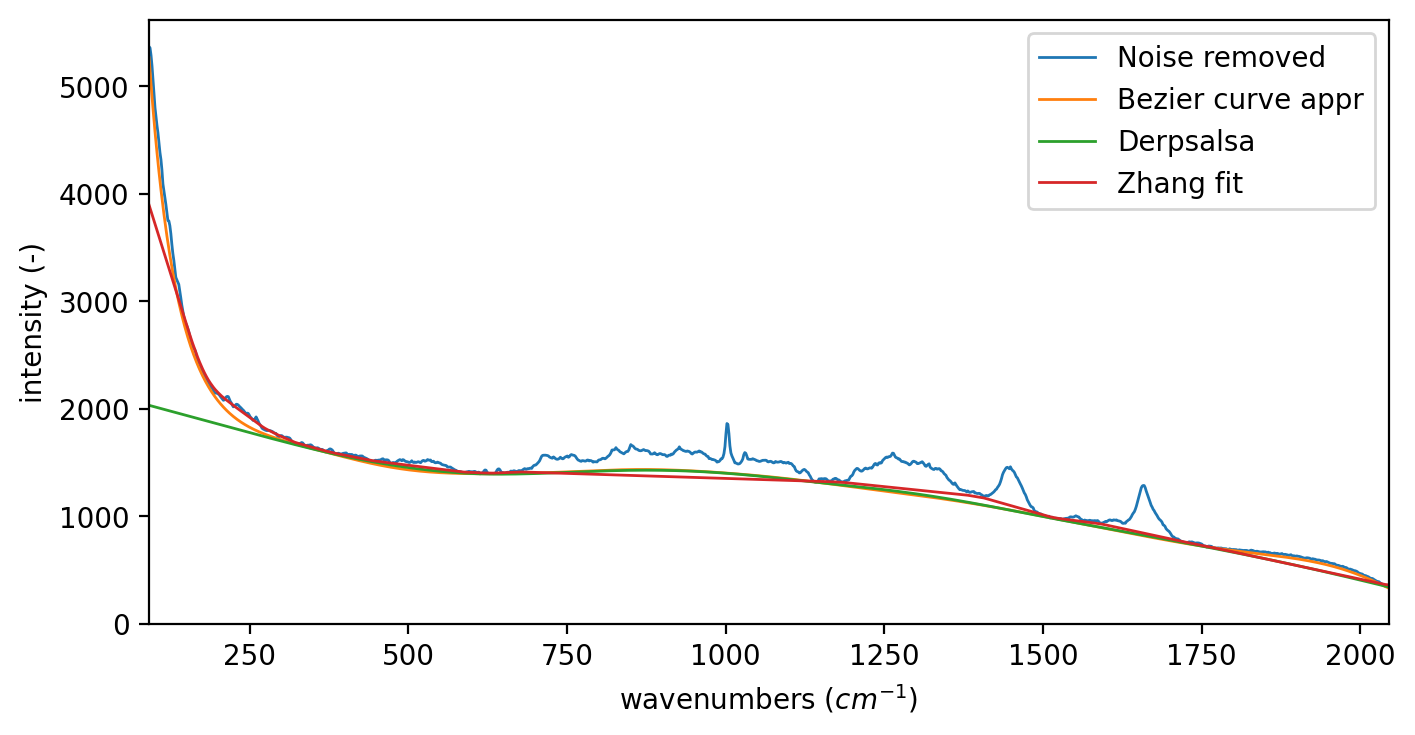

In [93]:
from BaselineRemoval import BaselineRemoval

plt.rcParams['figure.figsize'] = (8.0, 4.0)
plt.rcParams['figure.dpi'] = 200
plt.rcParams['lines.linewidth'] = 1

split = splitting.split(x, size=x.shape[0], FWHM=400, segment_width=450, algorithm="Bezier curve")

proposed_error = []
ALS_error = []
zhang_error = []

LEFT = 300

def calc_error(raw, photo):
    return [error.MSE(raw, photo), error.MSGE(photo), error.MAPE(raw, photo)]

for j, raw in enumerate(raw_lst):
    photo = split(raw.reshape(1,-1))[0]
    photo_ALS = derpsalsa.derpsalsa_baseline(x, raw, als_lambda=1e3, als_p_weight=1e-5, display=0)
    baseObj = BaselineRemoval(raw)
    photo_zhangfit = raw - baseObj.ZhangFit(lambda_=50, itermax=30)

    proposed_error.append(calc_error(raw, photo) + calc_error(raw[:LEFT], photo[:LEFT]) + calc_error(raw[LEFT:], photo[LEFT:]))
    ALS_error.append(calc_error(raw, photo_ALS) + calc_error(raw[:LEFT], photo_ALS[:LEFT]) + calc_error(raw[LEFT:], photo_ALS[LEFT:]))
    zhang_error.append(calc_error(raw, photo_zhangfit) + calc_error(raw[:LEFT], photo_zhangfit[:LEFT]) + calc_error(raw[LEFT:], photo_zhangfit[LEFT:]))

    plt.plot(x, raw, label="Noise removed")
    plt.plot(x, photo.reshape(-1), label="Bezier curve appr")
    plt.plot(x, photo_ALS, label="Derpsalsa")
    plt.plot(x, photo_zhangfit, label="Zhang fit")
    plt.ylim(0)
    plt.xlim(x[0], x[-1])
    plt.xlabel(r"wavenumbers ($cm^{-1}$)")
    plt.ylabel("intensity (-)")
    plt.legend()
    plt.show()
    break
    if not j % 100:
        print(f"{j/len(raw_lst)*100}% progress")
    if j > 500:
        break


In [90]:
error1 = np.array(copy.copy(proposed_error))
error2 = np.array(copy.copy(ALS_error))
error3 = np.array(copy.copy(zhang_error))

In [91]:
print(f"{np.mean(error1, 0)},\t {np.std(error1, 0)}")
print(f"{np.mean(error2, 0)},\t {np.std(error2, 0)}")
print(f"{np.mean(error3, 0)},\t {np.std(error3, 0)}")

[1.69137979e+04 1.91677718e+02 1.16930566e-01 1.07818224e+04
 7.99870778e+02 5.44011455e-02 1.88461432e+04 6.59644235e-01
 1.36635216e-01],	 [4.25474274e+03 4.70018347e+01 1.50550949e-02 3.07415338e+03
 1.96458126e+02 6.07426099e-03 4.83241681e+03 2.49805528e-01
 1.83339009e-02]
[1.67713767e+05 1.53324336e+00 1.54366224e-01 6.42454902e+05
 4.41391888e+00 1.63907684e-01 1.81104676e+04 6.28593028e-01
 1.51359462e-01],	 [4.30738861e+04 3.27525562e-01 1.69773797e-02 1.66614212e+05
 8.63225540e-01 1.51533839e-02 4.55083226e+03 2.14697113e-01
 1.79838416e-02]
[6.36831290e+04 4.27951291e+01 2.29822940e-01 7.28415104e+04
 1.77885137e+02 3.35827413e-02 6.07970844e+04 3.65830245e-01
 2.91663339e-01],	 [1.69133753e+04 1.02509884e+01 2.87543599e-02 1.77378198e+04
 4.28720215e+01 2.27023388e-03 1.75786122e+04 1.88900003e-01
 3.73719223e-02]


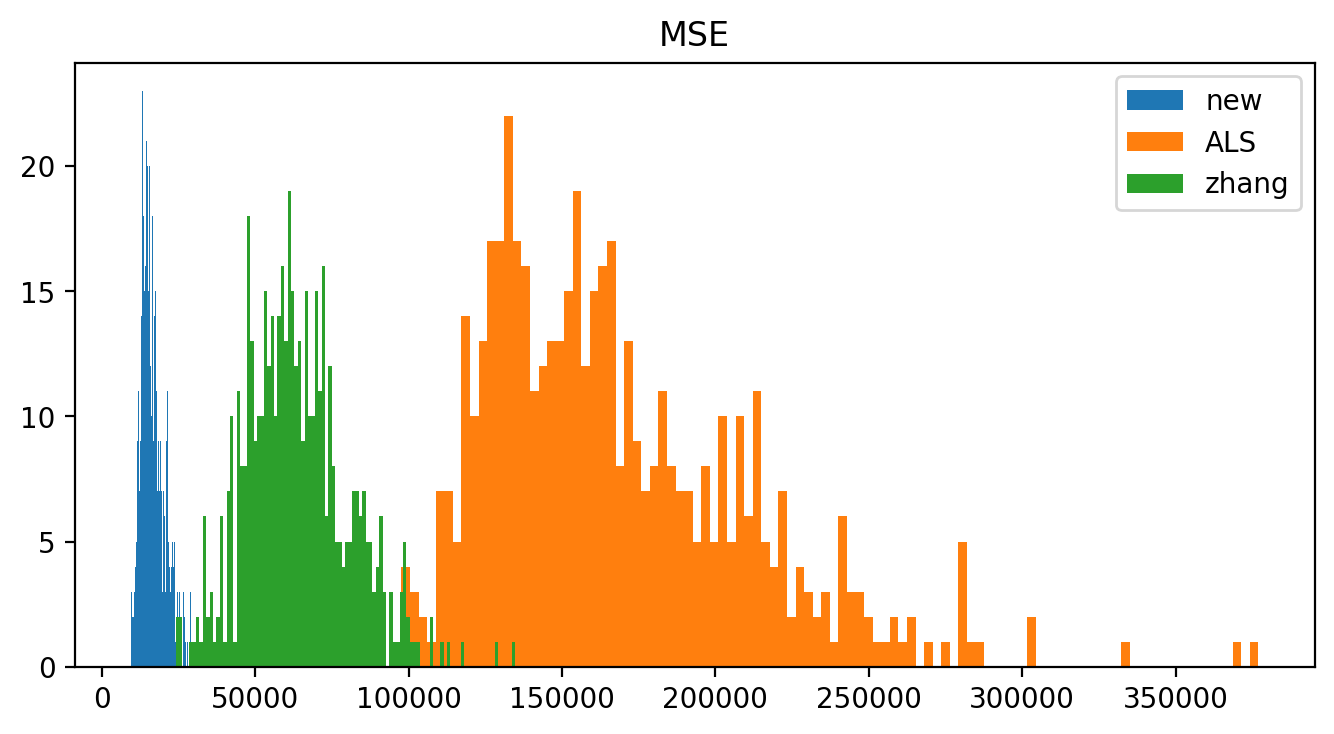

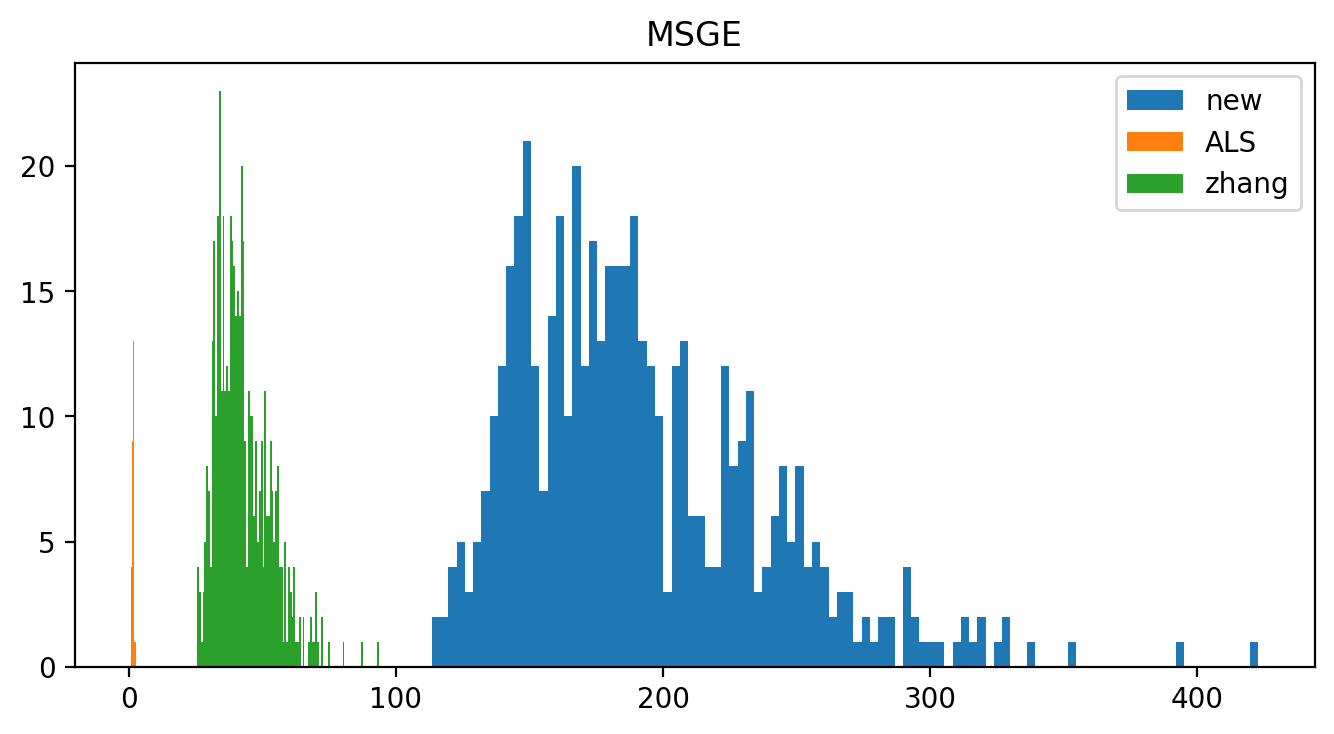

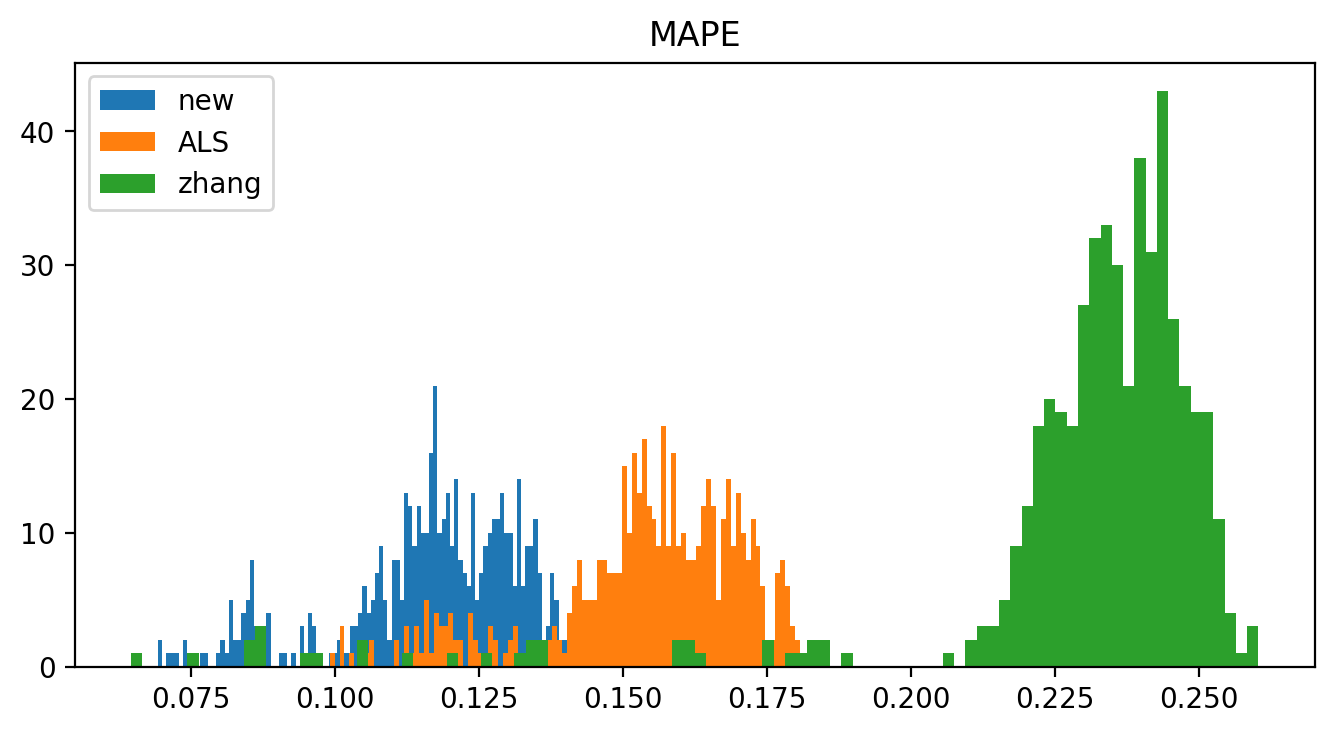

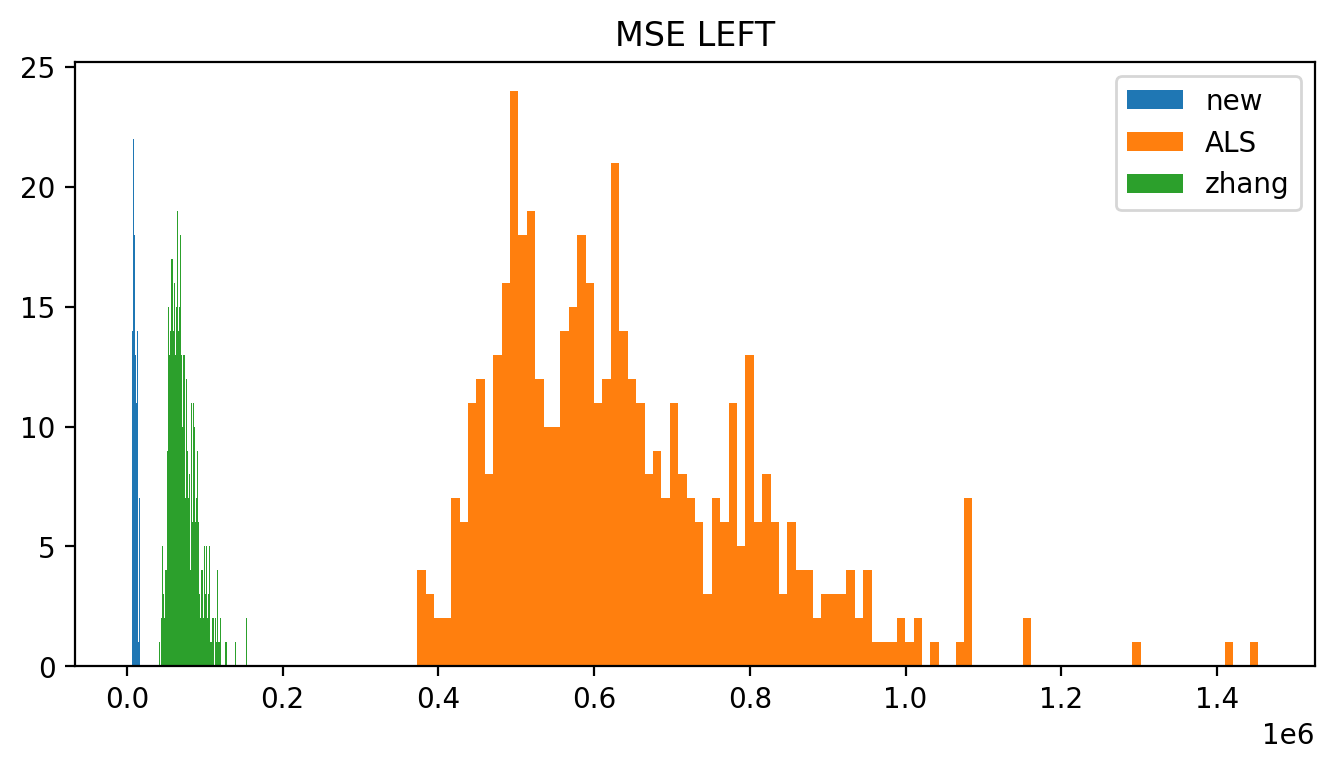

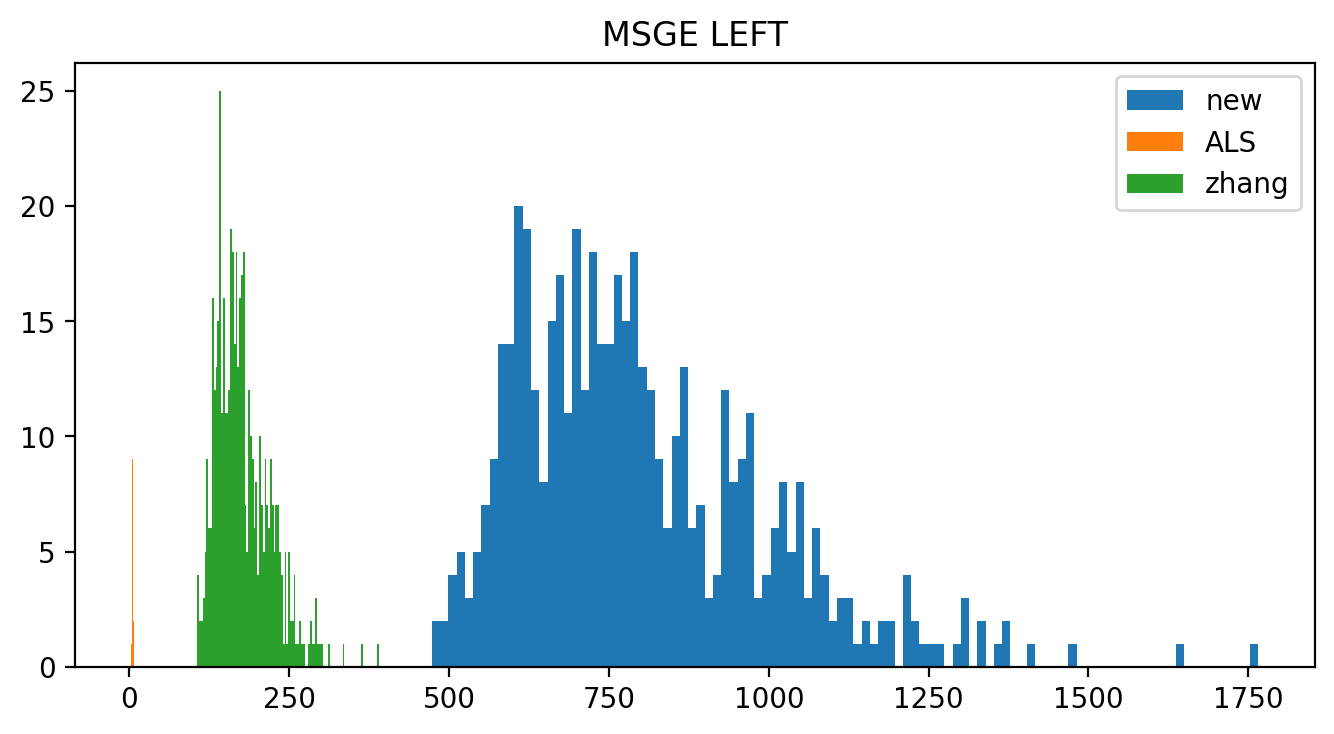

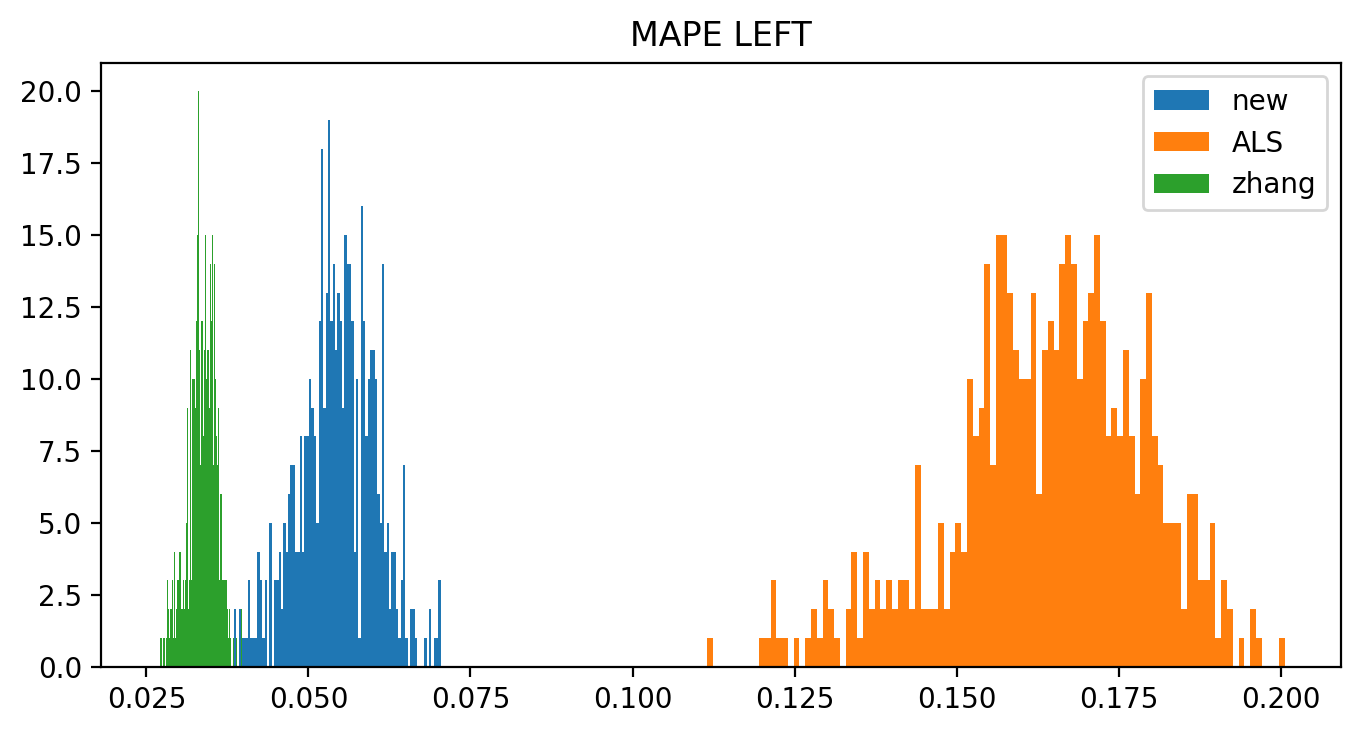

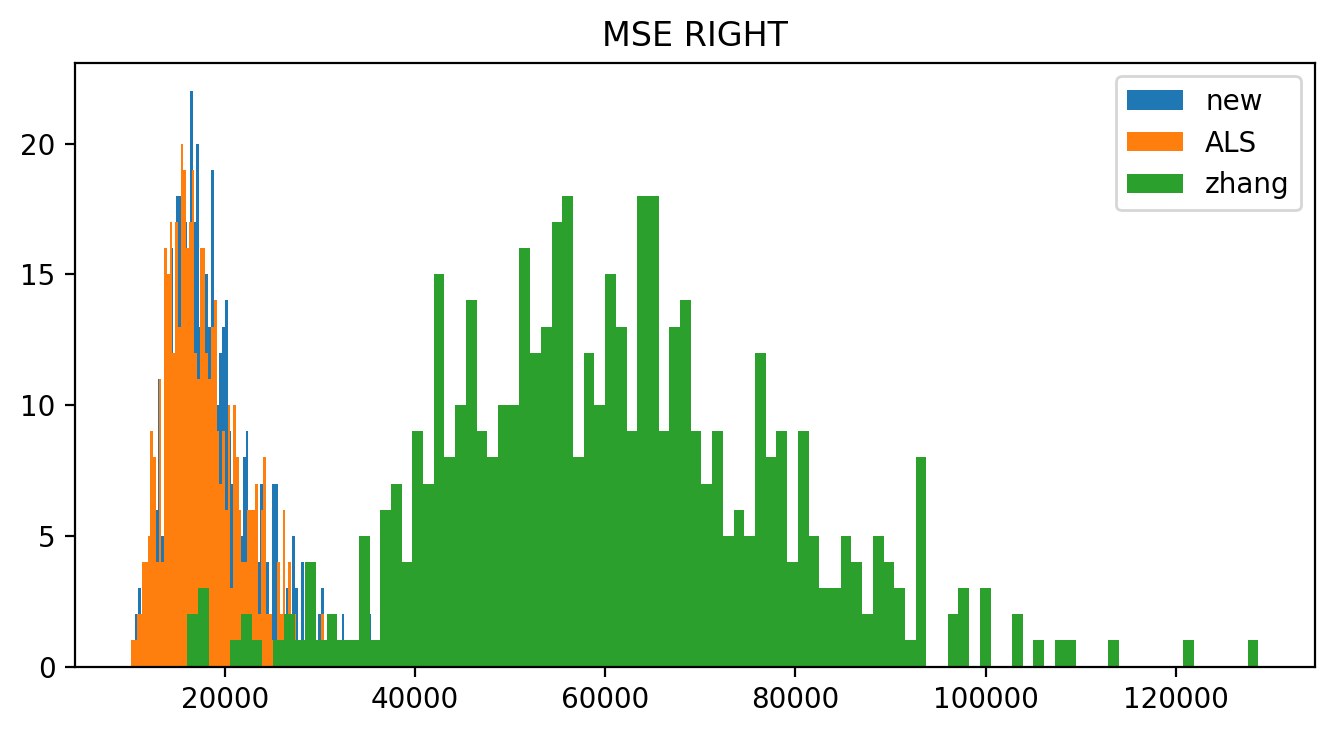

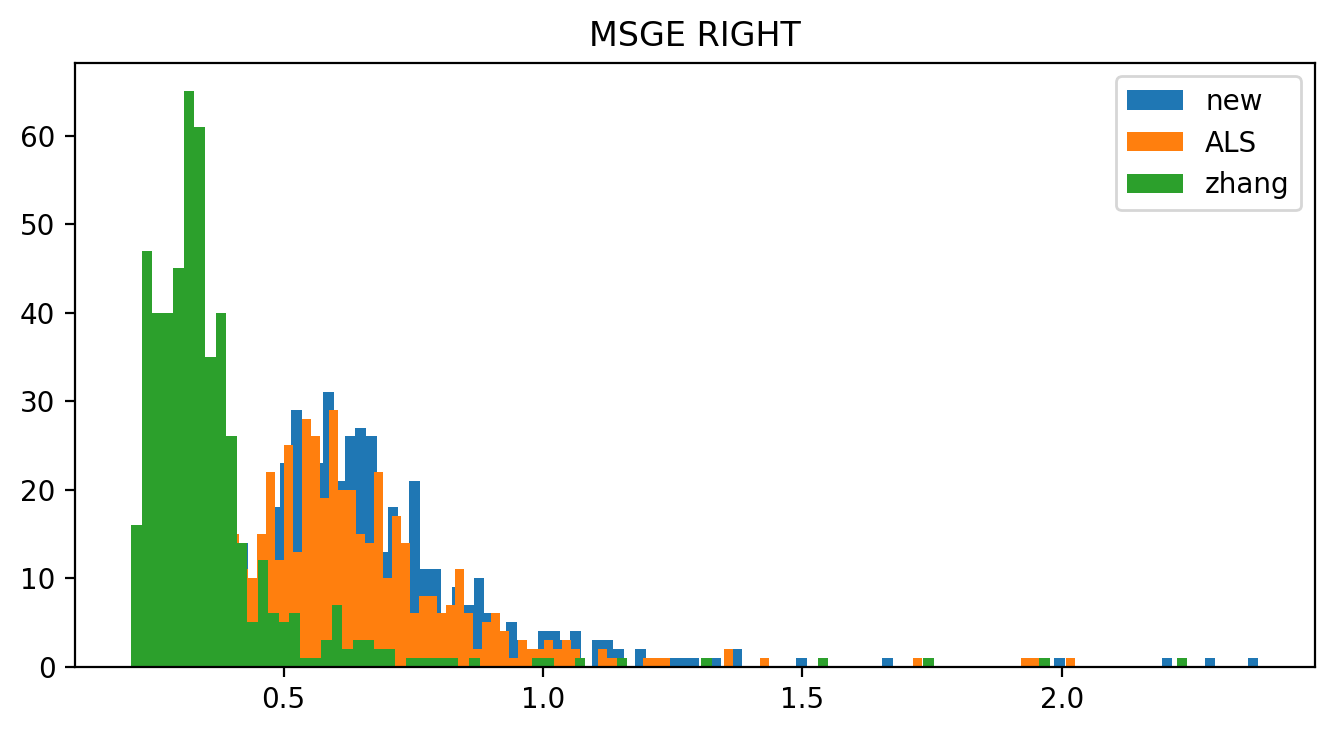

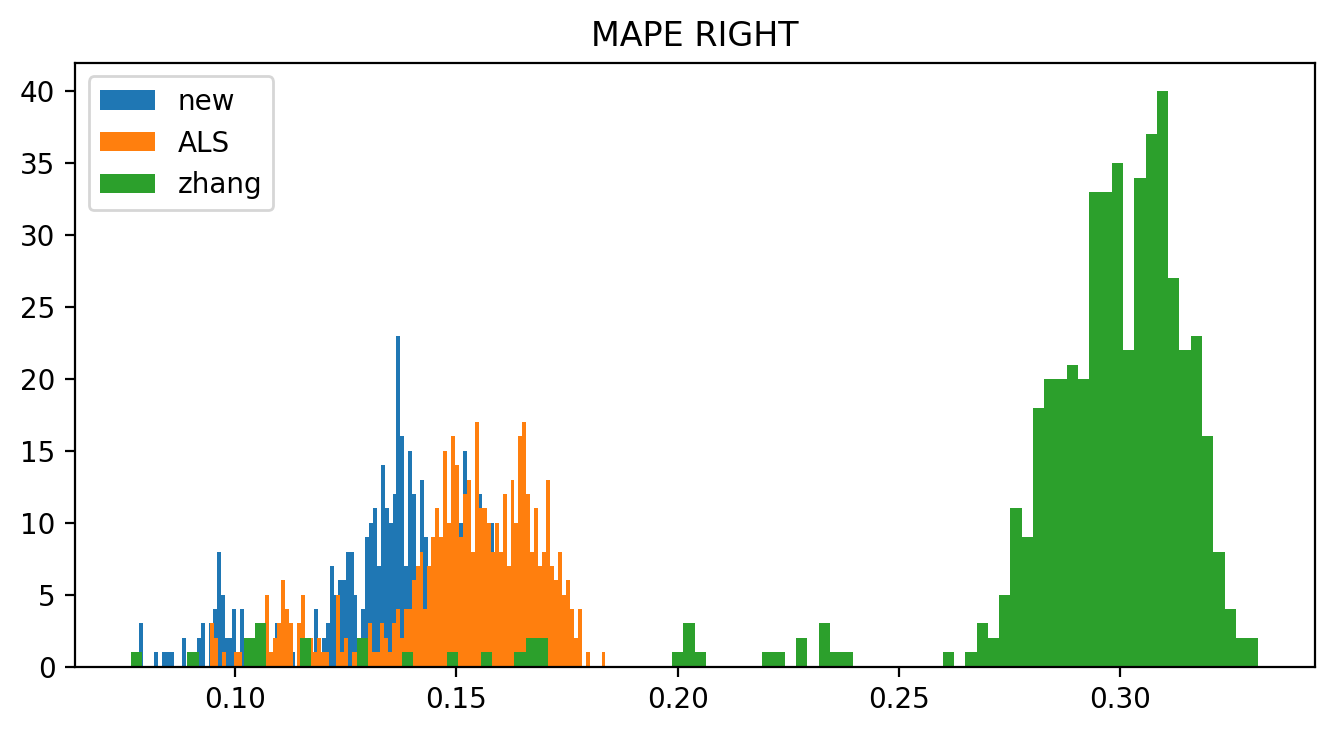

In [92]:
plt.title("MSE")
plt.hist(error1[:,0], 100, label="new")
plt.hist(error2[:,0], 100, label="ALS")
plt.hist(error3[:,0], 100, label="zhang")
plt.legend()
plt.show()

plt.title("MSGE")
plt.hist(error1[:,1], 100, label="new")
plt.hist(error2[:,1], 100, label="ALS")
plt.hist(error3[:,1], 100, label="zhang")
plt.legend()
plt.show()

plt.title("MAPE")
plt.hist(error1[:,2], 100, label="new")
plt.hist(error2[:,2], 100, label="ALS")
plt.hist(error3[:,2], 100, label="zhang")
plt.legend()
plt.show()

plt.title("MSE LEFT")
plt.hist(error1[:,3], 100, label="new")
plt.hist(error2[:,3], 100, label="ALS")
plt.hist(error3[:,3], 100, label="zhang")
plt.legend()
plt.show()

plt.title("MSGE LEFT")
plt.hist(error1[:,4], 100, label="new")
plt.hist(error2[:,4], 100, label="ALS")
plt.hist(error3[:,4], 100, label="zhang")
plt.legend()
plt.show()

plt.title("MAPE LEFT")
plt.hist(error1[:,5], 100, label="new")
plt.hist(error2[:,5], 100, label="ALS")
plt.hist(error3[:,5], 100, label="zhang")
plt.legend()
plt.show()

plt.title("MSE RIGHT")
plt.hist(error1[:,6], 100, label="new")
plt.hist(error2[:,6], 100, label="ALS")
plt.hist(error3[:,6], 100, label="zhang")
plt.legend()
plt.show()

plt.title("MSGE RIGHT")
plt.hist(error1[:,7], 100, label="new")
plt.hist(error2[:,7], 100, label="ALS")
plt.hist(error3[:,7], 100, label="zhang")
plt.legend()
plt.show()

plt.title("MAPE RIGHT")
plt.hist(error1[:,8], 100, label="new")
plt.hist(error2[:,8], 100, label="ALS")
plt.hist(error3[:,8], 100, label="zhang")
plt.legend()
plt.show()

